# Calculate Restaurant Edges
Program to generate CSV file with edges between restaurants who are less than DIST_MAX meters away from each other.

Using Google Colab.

In [1]:
import json
import pandas as pd
import numpy as np
import math
import time

In [2]:
from google.colab import files
uploaded = files.upload()

Saving 2017-2018_restaurants.csv to 2017-2018_restaurants.csv


### Reading the data

In [3]:
import io
restaurants_df = pd.read_csv(io.BytesIO(uploaded['2017-2018_restaurants.csv']))

In [4]:
restaurants_df.fillna(0, inplace=True)

In [5]:
restaurants_df.head(6)

,business_id,city,state,latitude,longitude,is_open,attributes,categories,hours,checkin_count,review_count,raw_stars,stars,weighted_stars,tip_count,first_date,last_date,visit_count,is_open_year_after
0,6iYb2HFDywm3zjuRg0shjw,Boulder,CO,40.017544,-105.283348,1,"{'RestaurantsTableService': 'True', 'WiFi': ""u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",79,49,3.714286,3.5,2.827977,4,2017-09-09 04:42:34,2021-01-22 05:20:38,132,True
1,tCbdrRPZA0oiIYSmHG3J0w,Portland,OR,45.588906,-122.593331,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...",181,24,3.500000,3.5,2.734268,4,2010-03-09 16:02:04,2021-01-21 17:55:35,209,True
2,D4JtQNTI4X3KcbzacDJsMw,Vancouver,BC,49.251342,-123.101333,1,"{'GoodForKids': 'True', 'Alcohol': ""u'none'"", ...","Restaurants, Thai","{'Monday': '17:0-21:0', 'Tuesday': '17:0-21:0'...",42,28,3.678571,3.5,3.284146,3,2010-09-26 04:03:35,2021-01-23 01:43:50,73,True
3,ufCxltuh56FF4-ZFZ6cVhg,Orlando,FL,28.513265,-81.374707,1,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, American (New), Bakeries, Dessert...","{'Tuesday': '11:0-18:0', 'Wednesday': '11:0-18...",42,38,4.631579,4.5,3.755860,5,2012-08-19 21:08:57,2020-12-29 16:25:19,85,True
4,dmbbf3AqeG61_QHRZi1M1w,Pine Castle,FL,28.450303,-81.380587,1,"{'BikeParking': 'False', 'RestaurantsPriceRang...","Automotive, American (Traditional), Gas Statio...",0,4,3,3.000000,3.0,1.789357,1,2015-06-11 16:44:12,2020-11-14 00:49:04,8,True
5,jGennaZUr2MsJyRhijNBfA,Boston,MA,42.363442,-71.025781,1,"{'NoiseLevel': ""u'average'"", 'BikeParking': 'F...","Sandwiches, Food, Restaurants, Breakfast & Bru...","{'Monday': '6:0-21:0', 'Tuesday': '6:0-21:0', ...",649,249,3.658635,3.5,3.223012,15,2005-12-13 23:59:04,2020-11-04 20:09:32,913,True


### Analyzing distribution of locations

In [6]:
restaurants_df.groupby("state").size().sort_values(ascending=False)

state
MA    6213
FL    4805
OR    4575
BC    3984
GA    3682
TX    3224
OH    2560
WA     528
CO     523
dtype: int64

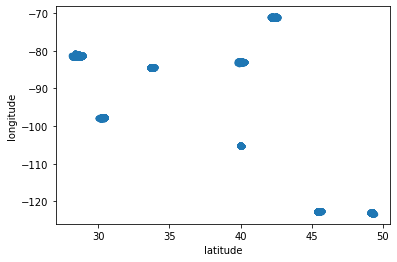

In [7]:
# Can clearly observe the 8 metropolitan areas
restaurants_df.plot.scatter(x="latitude", y="longitude")

In [8]:
restaurants_df.groupby("city").size().sort_values(ascending=False)[:10]

city
Portland     3418
Austin       2928
Vancouver    2814
Atlanta      2438
Orlando      2374
Boston       1622
Columbus     1497
Richmond      484
Cambridge     449
Boulder       410
dtype: int64

### Get Dataframes for each Metropolitan Areas

In [9]:
boston_df = restaurants_df[restaurants_df["state"] == "MA"]
vancouver_df = restaurants_df[restaurants_df["state"] == "BC"]
orlando_df = restaurants_df[restaurants_df["state"] == "FL"]
austin_df = restaurants_df[restaurants_df["state"] == "TX"]
portland_df = restaurants_df[restaurants_df["state"].isin(["WA", "OR"])]
atlanta_df = restaurants_df[restaurants_df["state"] == "GA"]
colombus_df = restaurants_df[restaurants_df["state"] == "OH"]
boulder_df = restaurants_df[restaurants_df["state"] == "CO"]

print(f"1. Boston (MA)\t\t{len(boston_df)}")
print(f"2. Vancouver (BC)\t{len(vancouver_df)}")
print(f"3. Orlando (FL)\t\t{len(orlando_df)}")
print(f"4. Austin (TX)\t\t{len(austin_df)}")
print(f"5. Portland (WA/OR)\t{len(portland_df)}")
print(f"6. Atlanta (GA)\t\t{len(atlanta_df)}")
print(f"7. Colombus (OH)\t{len(colombus_df)}")
print(f"8. Boulder (CO)\t\t{len(boulder_df)}")

1. Boston (MA)		6213
2. Vancouver (BC)	3984
3. Orlando (FL)		4805
4. Austin (TX)		3224
5. Portland (WA/OR)	5103
6. Atlanta (GA)		3682
7. Colombus (OH)	2560
8. Boulder (CO)		523


In [10]:
boulder_df.head()

,business_id,city,state,latitude,longitude,is_open,attributes,categories,hours,checkin_count,review_count,raw_stars,stars,weighted_stars,tip_count,first_date,last_date,visit_count,is_open_year_after
0,6iYb2HFDywm3zjuRg0shjw,Boulder,CO,40.017544,-105.283348,1,"{'RestaurantsTableService': 'True', 'WiFi': ""u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",79,49,3.714286,3.5,2.827977,4,2017-09-09 04:42:34,2021-01-22 05:20:38,132,True
12,Of6xu3pY3eHe2yhiyz2dvg,Boulder,CO,40.033678,-105.259103,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Restaurants, Tex-Mex, Tacos, Fast Food, Breakf...","{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W...",5,6,2.333333,2.5,1.702007,4,2010-11-01 06:48:12,2021-01-09 04:25:01,15,True
34,_8Hejg5Q-_izIhLvq2ocnw,Boulder,CO,40.070694,-105.200376,1,"{'BikeParking': 'True', 'GoodForMeal': ""{'dess...","Restaurants, Mexican","{'Monday': '11:0-20:0', 'Tuesday': '11:0-20:0'...",234,96,3.479167,3.5,2.471284,10,2014-12-17 16:02:48,2021-01-11 22:40:21,340,True
117,or-Kyw7kmNin1pWbu2RLJw,Boulder,CO,40.020092,-105.277655,1,"{'RestaurantsReservations': 'False', 'Business...","Cajun/Creole, Restaurants, Breakfast & Brunch,...","{'Monday': '7:0-14:0', 'Tuesday': '7:0-14:0', ...",147,119,4.117647,4.0,3.369297,10,2006-02-25 00:49:04,2021-01-25 21:46:03,276,True
303,e5cE2ffPTJmK6pStlx3b_Q,Boulder,CO,40.026903,-105.253445,0,"{'RestaurantsAttire': ""'casual'"", 'BusinessAcc...","Restaurants, Cafes, Coffee & Tea, Food, Bubble...","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",105,7,3.857143,4.0,3.940610,2,2007-06-29 21:35:56,2019-10-28 22:58:42,114,True


### Generate Edges

#### Idea:
- Calculate distance between every location within each metropolitan area (by state)
- Use haversine distance

In [32]:
DIST_MAX = 500

In [59]:
edges = [] # each edge is a tuple (id1, id2, distance) representing the business IDs

In [13]:
metropolitan_areas = [boston_df, vancouver_df, orlando_df, austin_df, portland_df, atlanta_df, colombus_df, boulder_df]

In [23]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res*1000, 2)

In [60]:
edges

[]

In [61]:
start_time = time.time()
count = 0
print("Processing...")

for index1, row1 in boulder_df.iterrows():
    count += 1
    if count % 500 == 0:
      print(f"Current count: {count}")
    for index2, row2 in boulder_df[boulder_df.index > index1].iterrows():
        dist = haversine_distance(row1[3], row1[4], row2[3], row2[4])
        if dist < DIST_MAX:
            edges.append((row1[0], row2[0], round(dist)))

total_time = (time.time() - start_time) / 60
print(f"Finished area in {round(total_time, 2)}")

Processing...
Current count: 500
Finished area in 0.43


In [62]:
len(edges)

8397

In [63]:
edges_df = pd.DataFrame(edges, columns=['id1', 'id2', 'distance'])

In [64]:
edges_df.head()

,id1,id2,distance
0,6iYb2HFDywm3zjuRg0shjw,DX6G8Vdu9wUx95Tzh6gEwA,117
1,6iYb2HFDywm3zjuRg0shjw,8zehGz9jnxPqXtOc7KaJxA,144
2,6iYb2HFDywm3zjuRg0shjw,u5friKeP4vez8B8DzHVBCQ,364
3,6iYb2HFDywm3zjuRg0shjw,EWOt6ZUkPC12D2E34VWnPQ,478
4,6iYb2HFDywm3zjuRg0shjw,1FHW194SVdJaytXXj0oN_A,394


In [65]:
edges_df.to_csv("./boulder_edges_df.csv", index=False)

In [66]:
files.download("boulder_edges_df.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>